#Assignment 3.2: LSTM ASSIGNMENT

This assignment is aimed at implementing LSTMs that we had learnt in class. In this task, we'll implement a model that takes text data as input and returns the emotion behind the text.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from wordcloud import WordCloud



## TEXT PRE-PROCESSING FOR NLP

**Import the dataset.**

In [ ]:
df=pd.read_csv("dataset.csv")

In [ ]:
df.head()

,sentiment,text
0,Negative,@xnausikaax oh no! where did u order from? tha...
1,Negative,A great hard training weekend is over. a coup...
2,Negative,"Right, off to work Only 5 hours to go until I..."
3,Negative,I am craving for japanese food
4,Negative,Jean Michel Jarre concert tomorrow gotta work...


**The dataset clearly has a large no. of redundant words, because that is simply how we humans talk. We'll first remove the stopwords.**


**Next, we'll remove some other info we dont need right now, like the handle names.**

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(text):
    # Remove @handle mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Join tokens back into a string
    return ' '.join(tokens)

df['text']= df['text'].apply(preprocess)
df.head()

,sentiment,text
0,Negative,oh u order thats horrible
1,Negative,A great hard training weekend couple days rest...
2,Negative,Right work Only hours go Im free xD
3,Negative,I craving japanese food
4,Negative,Jean Michel Jarre concert tomorrow got ta work...


**Now, we'll perform stemming, wherein we'll reduce the words to their root form.**

In [ ]:
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
def stem_text(text):
    tokens = word_tokenize(text)
    stemmed = [stemmer.stem(t) for t in tokens]
    return ' '.join(stemmed)

df['text'] = df['text'].apply(stem_text)
df.head()

,sentiment,text
0,Negative,oh u order that horribl
1,Negative,a great hard train weekend coupl day rest let ...
2,Negative,right work onli hour go im free xd
3,Negative,i crave japanes food
4,Negative,jean michel jarr concert tomorrow got ta work ...


**Now that we are done with pre-processing, lets see what the gist of the data is that our model should capture.**
**Generate a word-cloud for the positive and negative words of the dataset.**

In [ ]:
positive_text = ' '.join(df[df['sentiment'] == 'Positive']['text'])
negative_text = ' '.join(df[df['sentiment'] == 'Negative']['text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

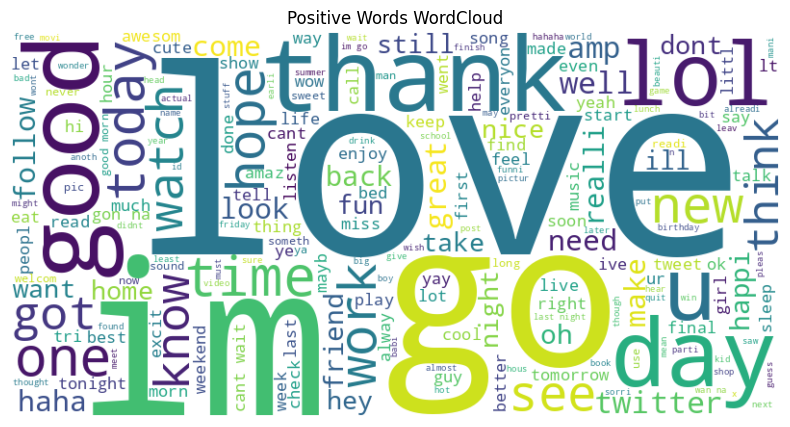

In [ ]:
# Plot Positive wordcloud
plt.figure(figsize=(10,5))
plt.title('Positive Words WordCloud')
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

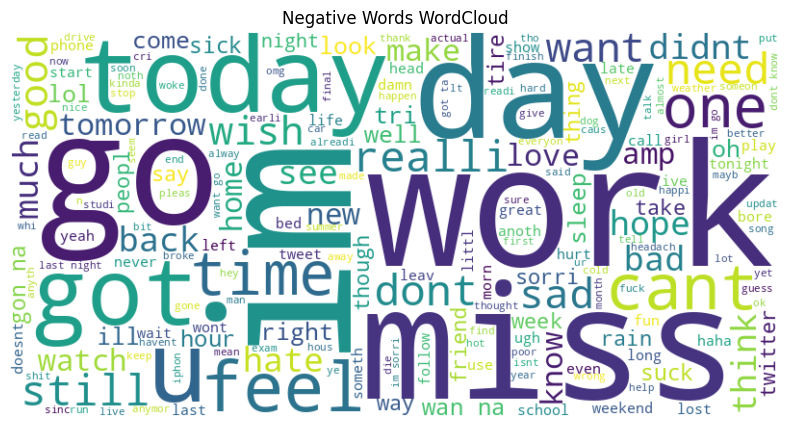

In [ ]:
# Plot Negative wordcloud
plt.figure(figsize=(10,5))
plt.title('Negative Words WordCloud')
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

**I'd like to point out that 'Work' is bigger in the negative words display than it is in the positive words one.**

## TRAINING

**We have now processed the data for training. It's time for us to split it into training and test splits.**

In [ ]:
X= df['text']
y= df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 9000
Test set size: 1000


**It is now time to convert our text sequences into numbers like the model will understand. Fit a tokenizer on the training dataset for the same. Let the vocab size be the no of unique words itself.**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None, oov_token=None)
# Fitting tokenizer
tokenizer.fit_on_texts(X_train)
# converting texts to sequences
sequences = tokenizer.texts_to_sequences(X_train)
# checking vocab size
vocab_size = len(tokenizer.word_index) + 1

print(f"Vocabulary Size: {vocab_size}")


Vocabulary Size: 11478


In [ ]:
word_index = tokenizer.word_index

**Now transform the training and testing word sequences.**

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test.tolist())

In [ ]:
print(X_train_sequences[1])
print(X_test_sequences[1])

[71, 1378, 33, 4163, 75, 1379, 68, 66, 4164, 392]
[32, 86, 739, 288, 2389, 2228, 558, 267, 415]


**It is necessary for the simplicity of the model that each text sequence be of the same length. Pad the sequences to make this possible.**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 36
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='pre')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='pre')

In [ ]:
print("Training Data:\n",X_train_padded[1])
print("Testing Data:\n",X_test_padded[1])


Training Data:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   71 1378
   33 4163   75 1379   68   66 4164  392]
Testing Data:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   32
   86  739  288 2389 2228  558  267  415]


**Label encode y.**

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Fit label encoder
y_train_encoded=label_encoder.fit_transform(y_train)
y_test_encoded=label_encoder.transform(y_test)

In [ ]:
print("Encoded training labels:", y_train_encoded)
print("Testing labels:", y_test_encoded)

Encoded training labels: [0 0 0 ... 1 0 1]
Testing labels: [1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1
 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0
 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1
 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0
 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0
 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0
 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0
 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 

**FOLLOWING CODE IS FOR CREATING WORD EMBEDDINGS. DON'T TOUCH IT.JUST REPLACE VOCAB_SIZE WITH THE VOCABULARY SIZE OBTAINED EARLIER.**

In [ ]:
!wget --no-check-certificate https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip


--2025-06-16 14:40:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.07MB/s    in 2m 43s  

2025-06-16 14:42:56 (5.05 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../content/best_model.hdf5'
MAX_SEQUENCE_LENGTH = 36
embeddings_index = {}
f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
embedding_layer = tf.keras.layers.Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)


Found 400000 word vectors.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

**You should read up on why we added the previous code block.The embedding layer created is to be used in the model. Use the model summary to build the rest. Compile the model with Adam and a suitable loss function.**

In [ ]:
MAX_SEQUENCE_LENGTH = 36
EMBEDDING_DIM = 100
VOCAB_SIZE = vocab_size

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(16, kernel_size=3, activation='relu')(x)
x = Bidirectional(LSTM(16))(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=sequence_input, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 36, 300)        │     3,443,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 36, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 34, 16)         │        14,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,462,585 (13.21 MB)

 Trainable params: 19,185 (74.94 KB)

 Non-trainable params: 3,443,400 (13.14 MB)

**Train the model on the train split, and validate it on the test split.**

In [ ]:
history=model.fit(X_train_padded, y_train_encoded, batch_size=32, epochs=10,validation_split=0.2)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5707 - loss: 0.6778 - val_accuracy: 0.6628 - val_loss: 0.6138
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6855 - loss: 0.6010 - val_accuracy: 0.6961 - val_loss: 0.5780
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7004 - loss: 0.5741 - val_accuracy: 0.6922 - val_loss: 0.5767
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7229 - loss: 0.5553 - val_accuracy: 0.6983 - val_loss: 0.5717
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7520 - loss: 0.5163 - val_accuracy: 0.7056 - val_loss: 0.5695
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7565 - loss: 0.5018 - val_accuracy: 0.6928 - val_loss: 0.5862
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7748 - loss: 0.4736 - val_accuracy: 0.6933 - val_loss: 0.5916
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7877 - loss: 0.4537 - val_

**Let's visualise the model's training history now.**

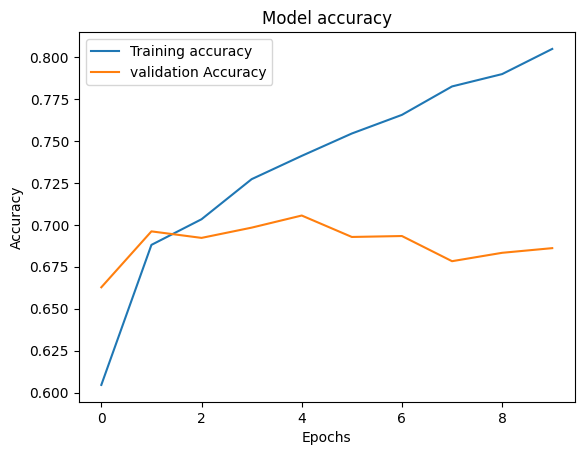

In [ ]:
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="validation Accuracy")
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


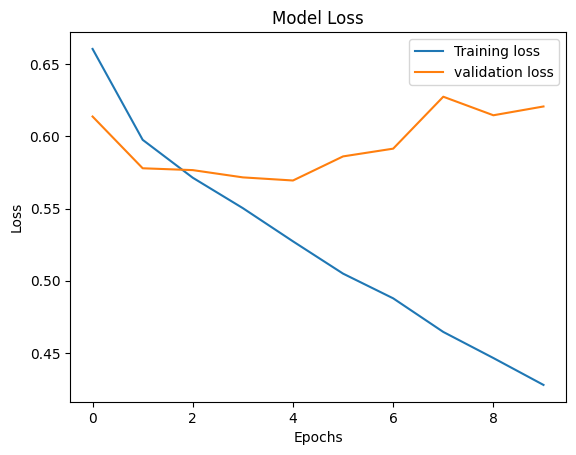

In [ ]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Lets see what the accuracy of the model is.**

In [ ]:
results = model.evaluate(X_test_padded,y_test_encoded)
print("Loss = ",results[0])
print("Accuracy = ",results[1]*100,"%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6826 - loss: 0.6456
Loss =  0.6188379526138306
Accuracy =  69.30000185966492 %


**Take a random input sequence from the text series. First predict on it nd gets its sentiment. Then decode the string using the tokenizer, etc. you've developed and print the string as well.**

In [ ]:
import random
random_index = random.randint(0, len(X_test_padded) - 1)
random_sequence_padded = X_test_padded[random_index]
original_text = X_test.iloc[random_index]
random_sequence_padded_input = np.expand_dims(random_sequence_padded, axis=0)
prediction = model.predict(random_sequence_padded_input)
predicted_sentiment = "Positive" if prediction[0][0] > 0.5 else "Negative"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


In [ ]:
print(f"Original Text: {original_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

Original Text: waitno no dont wan na screw rjor i cant screw taylor
Predicted Sentiment: Negative


In [ ]:
def decode_sequence(sequence):
  decoded_words = [reverse_word_index.get(i, '?') for i in sequence if i != 0]
  return ' '.join(decoded_words)

In [ ]:
decoded_string = decode_sequence(random_sequence_padded)
print(f"Decoded String (from padded sequence): {decoded_string}")

Decoded String (from padded sequence): no dont wan na screw i cant screw taylor


**We can try this on a random string as well.**

In [ ]:
input_str='I hate everyone on earth!'
seq = tokenizer.texts_to_sequences([input_str])
padded_input = pad_sequences(seq, maxlen=100, padding='post')
pred = model.predict(padded_input)
predicted_sentiment = "Positive" if pred[0][0] > 0.5 else "Negative"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


In [ ]:
print(f"Original Text: {input_str}")
print(f"Predicted Sentiment: {predicted_sentiment}")
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

Original Text: I hate everyone on earth!
Predicted Sentiment: Negative


## GOOD JOB!